In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
from PIL import Image

from pytorch3d.renderer import FoVPerspectiveCameras, OpenGLPerspectiveCameras, PerspectiveCameras, SfMPerspectiveCameras
from pytorch3d.vis.plotly_vis import plot_scene

from dataset import CustomDataset, Co3dDataset
from eval import evaluate_coordinate_ascent, evaluate_mst
from models import get_model
from utils import unnormalize_image, view_color_coded_images_from_path, view_color_coded_images_from_tensor

In [2]:
def compute_angular_error_batch(rotation1, rotation2):
    R_rel = np.einsum("Bij,Bjk ->Bik", rotation1.transpose(0, 2, 1), rotation2)
    t = (np.trace(R_rel, axis1=1, axis2=2) - 1) / 2
    theta = np.arccos(np.clip(t, -1, 1))
    return theta * 180 / np.pi

def get_permutations(num_images, eval_time=False):
    if not eval_time:
        permutations = []
        for i in range(1, num_images):
            for j in range(num_images - 1):
                if i > j:
                    permutations.append((j, i))
    else:
        permutations = []
        for i in range(0, num_images):
            for j in range(0, num_images):
                if i != j:
                    permutations.append((j, i))

    return permutations

def get_n_consistent_cameras(R_pred, num_frames):
    R_pred_n = torch.zeros(num_frames, 3, 3)
    R_pred_n[0] = torch.eye(3)
    for k, (i, j) in enumerate(get_permutations(num_frames, eval_time=True)):
        if i == 0:
            R_pred_n[j] = R_pred[k]

    return R_pred_n

def full_scene_scale(R, T):
    # Calculate centroid of cameras in batch
    cameras = FoVPerspectiveCameras(R=R, T=T)
    cc = cameras.get_camera_center()
    centroid = torch.mean(cc, dim=0)

    # Determine distance from centroid to each camera
    diffs = cc - centroid
    norms = torch.linalg.norm(diffs, dim=1)

    # Scene scale is the distance from the centroid to the furthest camera
    furthest_index = torch.argmax(norms).item()
    scale = norms[furthest_index].item()
    return scale

def compute_optimal_translation_alignment(T_A, T_B, R_B):
    """
    Assuming right-multiplied rotation matrices.

    E.g., for world2cam R and T, a world coordinate is transformed to camera coordinate
    system using X_cam = X_world.T @ R + T = R.T @ X_world + T

    Finds s, t that minimizes || T_A - (s * T_B + R_B.T @ t) ||^2

    Args:
        T_A (torch.Tensor): Target translation (N, 3).
        T_B (torch.Tensor): Initial translation (N, 3).
        R_B (torch.Tensor): Initial rotation (N, 3, 3).

    Returns:
        T_A_hat (torch.Tensor): s * T_B + t @ R_B (N, 3).
        scale s (torch.Tensor): (1,).
        translation t (torch.Tensor): (1, 3).
    """
    n = len(T_A)

    T_A = T_A.unsqueeze(2)
    T_B = T_B.unsqueeze(2)

    A = torch.sum(T_B * T_A)
    B = (T_B.transpose(1, 2) @ R_B.transpose(1, 2)).sum(0) @ (R_B @ T_A).sum(0) / n
    C = torch.sum(T_B * T_B)
    D = (T_B.transpose(1, 2) @ R_B.transpose(1, 2)).sum(0)
    E = (D * D).sum() / n

    s = (A - B.sum()) / (C - E.sum())

    t = (R_B @ (T_A - s * T_B)).sum(0) / n

    T_A_hat = s * T_B + R_B.transpose(1, 2) @ t

    return T_A_hat.squeeze(2), s, t.transpose(1, 0)

def get_error(R_pred, T_pred, R_gt, T_gt, gt_scene_scale):
    T_A_hat, _, _ = compute_optimal_translation_alignment(T_gt, T_pred, R_pred)
    norm = torch.linalg.norm(T_gt - T_A_hat, dim=1) / gt_scene_scale
    norms = np.ndarray.tolist(norm.detach().cpu().numpy())
    norms = np.array(norms)
    return norms, T_A_hat

def blender2torch3d_objaverse(blw2blc):
    homo = np.array([0,0,0,1])
    R_blc2blw = blw2blc[:3, :3].T
    T_blc2blw = -R_blc2blw @ blw2blc[:3, 3]
    blc2blw = np.concatenate([R_blc2blw, T_blc2blw[...,None]], axis=-1)
    blc2blw = np.concatenate([blc2blw, homo[None,...]], axis=0)
    # * blender to opengl
    blw2glw = np.array([[1,0,0,0], [0,0,1,0], [0,-1,0,0], [0,0,0,1]])
    glw2blc = np.linalg.inv(blw2glw @ blc2blw)
    # * opengl to pytorch3d
    blc2pyc = np.array([[-1,0,0,0], [0,1,0,0], [0,0,-1,0], [0,0,0,1]])
    glw2pyc = blc2pyc @ glw2blc
    return glw2pyc

def cartesian_to_spherical(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    z = np.sqrt(xy + xyz[:,2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    azimuth = np.arctan2(xyz[:,1], xyz[:,0])
    return np.array([theta, azimuth, z])

def get_T(target_RT, cond_RT):
    R, T = target_RT[:3, :3], target_RT[:, -1]
    T_target = -R.T @ T

    R, T = cond_RT[:3, :3], cond_RT[:, -1]
    T_cond = -R.T @ T

    theta_cond, azimuth_cond, z_cond = cartesian_to_spherical(T_cond[None, :])
    theta_target, azimuth_target, z_target = cartesian_to_spherical(T_target[None, :])
    
    d_theta = theta_target - theta_cond
    d_azimuth = (azimuth_target - azimuth_cond) % (2 * np.pi)
    d_z = z_target - z_cond

    return d_theta, d_azimuth, d_z

In [32]:
# Load pretrained weights
model, args = get_model(
    model_dir="/home/xinyang/scratch/zelin_dev/threetothreed/relposepp/ckpts_refine_objaverse/finetune_best_new/1021_0518_LR1e-05_N8_RandomNTrue_B28_Pretrained0812_0954_AMP_TROURS_DDP", # objaverse blender coord
    # model_dir='/home/xinyang/scratch/zelin_dev/threetothreed/relposepp/ckpts_refine_objaverse/finetune_best_new/1022_1317_LR1e-05_N8_RandomNTrue_B32_Pretrained0812_0954_AMP_TROURS_DDP',
    num_images=3,
    device="cuda"
)

Loading checkpoint ckpt_000130000.pth


In [68]:
image_dirs = [f"/home/xinyang/scratch/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice/{i}/images" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice")]
mask_dirs = [f"/home/xinyang/scratch/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice/{i}/masks" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice")]
pose_dirs = [f"/home/xinyang/scratch/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice/{i}/poses" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice")]

In [ ]:
print("== Test Performance ===")
for image_dir,mask_dir,pose_dir in zip(image_dirs,mask_dirs,pose_dirs):
    dataset = CustomDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
    )
    num_frames = dataset.n
    batch = dataset.get_data(ids=np.arange(num_frames))
    images = batch["image"].to("cuda:0")
    crop_params = batch["crop_params"].to("cuda:0")
    batched_images, batched_crop_params = images.unsqueeze(0), crop_params.unsqueeze(0)

    _, hypothesis = evaluate_mst(
        model=model,
        images=batched_images,
        crop_params=batched_crop_params,
    )
    R_pred = np.stack(hypothesis)


    # Regress to optimal translation
    with torch.no_grad():
        _, logits, T_pred = model(
            images=batched_images,
            crop_params=batched_crop_params,
        )
        loss_rot = -torch.mean(torch.log_softmax(logits, dim=-1)[:, :, 0]).item()

    R_pred_rel, hypothesis = evaluate_coordinate_ascent(
        model=model,
        images=batched_images,
        crop_params=batched_crop_params,
    )
    R_final = np.stack(hypothesis)

    R_gt = []
    T_gt = []
    for i in sorted(os.listdir(pose_dir)):
        pose = np.load(f'{pose_dir}/{i}')
        R_gt.append(pose[:3,:3])
        T_gt.append(torch.tensor(pose[:3,-1]))
    R_gt = np.stack(R_gt)
    T_gt = torch.stack(T_gt)
    permutations = get_permutations(num_frames, eval_time=True)
    n_p = len(permutations)
    relative_rotation = np.zeros((n_p, 3, 3))
    for k, t in enumerate(permutations):
        i, j = t
        relative_rotation[k] = R_gt[i].T @ R_gt[j]
    R_gt_rel = relative_rotation

    error_R = compute_angular_error_batch(R_pred_rel, R_gt_rel)

    R_pred_n = get_n_consistent_cameras(torch.from_numpy(R_pred_rel), num_frames)
    gt_scene_scale = full_scene_scale(torch.from_numpy(R_gt), T_gt)
    error_t, A_hat = get_error(R_pred_n.float(), T_pred.cpu().float(), R_gt, T_gt.float(), gt_scene_scale)

    print(f'class name:{image_dir.split("/")[-2]} loss_rot: {loss_rot:.3f} rotation error: {error_R.mean():.3f} translation error: {error_t.mean():.3f}')

In [ ]:
image_dirs = [f"/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice/{i}/images" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice")]
mask_dirs = [f"/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice/{i}/masks" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice")]
pose_dirs = [f"/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice/{i}/poses" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice")]

In [ ]:
print("== Train Performance ===")
for image_dir,mask_dir,pose_dir in zip(image_dirs,mask_dirs,pose_dirs):
    dataset = CustomDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
    )
    num_frames = dataset.n
    batch = dataset.get_data(ids=np.arange(num_frames))
    images = batch["image"].to("cuda:0")
    crop_params = batch["crop_params"].to("cuda:0")
    batched_images, batched_crop_params = images.unsqueeze(0), crop_params.unsqueeze(0)

    _, hypothesis = evaluate_mst(
        model=model,
        images=batched_images,
        crop_params=batched_crop_params,
    )
    R_pred = np.stack(hypothesis)


    # Regress to optimal translation
    with torch.no_grad():
        _, logits, T_pred = model(
            images=batched_images,
            crop_params=batched_crop_params,
        )
        loss_rot = -torch.mean(torch.log_softmax(logits, dim=-1)[:, :, 0]).item()

    R_pred_rel, hypothesis = evaluate_coordinate_ascent(
        model=model,
        images=batched_images,
        crop_params=batched_crop_params,
    )
    R_final = np.stack(hypothesis)

    R_gt = []
    T_gt = []
    for i in sorted(os.listdir(pose_dir)):
        pose = np.load(f'{pose_dir}/{i}')
        R_gt.append(pose[:3,:3])
        T_gt.append(torch.tensor(pose[:3,-1]))
    R_gt = np.stack(R_gt)
    T_gt = torch.stack(T_gt)
    permutations = get_permutations(num_frames, eval_time=True)
    n_p = len(permutations)
    relative_rotation = np.zeros((n_p, 3, 3))
    for k, t in enumerate(permutations):
        i, j = t
        relative_rotation[k] = R_gt[i].T @ R_gt[j]
    R_gt_rel = relative_rotation

    error_R = compute_angular_error_batch(R_pred_rel, R_gt_rel)

    R_pred_n = get_n_consistent_cameras(torch.from_numpy(R_pred_rel), num_frames)
    gt_scene_scale = full_scene_scale(torch.from_numpy(R_gt), T_gt)
    error_t, A_hat = get_error(R_pred_n.float(), T_pred.cpu().float(), R_gt, T_gt.float(), gt_scene_scale)

    print(f'class name:{image_dir.split("/")[-2]} loss_rot: {loss_rot:.3f} rotation error: {error_R.mean():.3f} translation error: {error_t.mean():.3f}')

In [65]:
image_dirs = [f"/home/xinyang/zelin_dev/threetothreed/dataset/GSO_blender_norandom/{i}/thumbnails" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/dataset/GSO_blender_norandom")]
mask_dirs = [f"/home/xinyang/zelin_dev/threetothreed/dataset/GSO_blender_norandom/{i}/masks" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/dataset/GSO_blender_norandom")]
pose_dirs = [f"/home/xinyang/zelin_dev/threetothreed/dataset/GSO_blender_norandom/{i}/poses" for i in os.listdir("/home/xinyang/zelin_dev/threetothreed/dataset/GSO_blender_norandom")]

In [66]:
print("== GSO Performance ===")
rot_loss_mean = []
trans_loss_mean = []
for image_dir,mask_dir,pose_dir in zip(image_dirs,mask_dirs,pose_dirs):
    dataset = CustomDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
    )
    num_frames = dataset.n
    batch = dataset.get_data(ids=np.arange(num_frames))
    images = batch["image"].to("cuda:0")
    crop_params = batch["crop_params"].to("cuda:0")
    batched_images, batched_crop_params = images.unsqueeze(0), crop_params.unsqueeze(0)

    _, hypothesis = evaluate_mst(
        model=model,
        images=batched_images,
        crop_params=batched_crop_params,
    )
    R_pred = np.stack(hypothesis)


    # Regress to optimal translation
    with torch.no_grad():
        _, logits, T_pred = model(
            images=batched_images,
            crop_params=batched_crop_params,
        )
        loss_rot = -torch.mean(torch.log_softmax(logits, dim=-1)[:, :, 0]).item()

    R_pred_rel, hypothesis = evaluate_coordinate_ascent(
        model=model,
        images=batched_images,
        crop_params=batched_crop_params,
    )
    R_final = np.stack(hypothesis)

    R_gt = []
    T_gt = []
    for i in sorted(os.listdir(pose_dir)):
        pose = np.load(f'{pose_dir}/{i}')
        R_gt.append(pose[:3,:3])
        T_gt.append(torch.tensor(pose[:3,-1]))
    R_gt = np.stack(R_gt)
    T_gt = torch.stack(T_gt)
    permutations = get_permutations(num_frames, eval_time=True)
    n_p = len(permutations)
    relative_rotation = np.zeros((n_p, 3, 3))
    for k, t in enumerate(permutations):
        i, j = t
        relative_rotation[k] = R_gt[i].T @ R_gt[j]
    R_gt_rel = relative_rotation

    error_R = compute_angular_error_batch(R_pred_rel, R_gt_rel)

    R_pred_n = get_n_consistent_cameras(torch.from_numpy(R_pred_rel), num_frames)
    gt_scene_scale = full_scene_scale(torch.from_numpy(R_gt), T_gt)
    error_t, A_hat = get_error(R_pred_n.float(), T_pred.cpu().float(), R_gt, T_gt.float(), gt_scene_scale)

    print(f'class name: {image_dir.split("/")[-2][:20]:<20} loss_rot: {loss_rot:.3f} rotation error: {error_R.mean():.3f} translation error: {error_t.mean():.3f}')

    rot_loss_mean.append(error_R)
    trans_loss_mean.append(error_t)

print(f'Mean! rot error: {np.mean(rot_loss_mean)} trans error: {np.mean(trans_loss_mean)}')


== GSO Performance ===
class name: Schleich_Lion_Action loss_rot: 13.122 rotation error: 75.807 translation error: 0.116
class name: Black_Decker_CM2035B loss_rot: 13.122 rotation error: 36.030 translation error: 0.066
class name: Schleich_Bald_Eagle  loss_rot: 13.122 rotation error: 48.711 translation error: 0.056
class name: Womens_Hikerfish_Boo loss_rot: 13.122 rotation error: 79.044 translation error: 0.185
class name: Circo_Fish_Toothbrus loss_rot: 13.122 rotation error: 33.717 translation error: 0.151
class name: Ortho_Forward_Facing loss_rot: 13.122 rotation error: 40.326 translation error: 0.191
class name: adistar_boost_m      loss_rot: 13.122 rotation error: 98.143 translation error: 0.273
class name: Toysmith_Windem_Up_F loss_rot: 13.122 rotation error: 95.107 translation error: 0.154
class name: Crosley_Alarm_Clock_ loss_rot: 13.122 rotation error: 60.513 translation error: 0.110
class name: Schleich_Hereford_Bu loss_rot: 13.122 rotation error: 31.165 translation error: 0.1

In [33]:

# * OBJAVERSE EVAL
IMAGE_DIR = "/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice/2f65cecb5f014787a9778359a947351b/images"
MASK_DIR = "/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice/2f65cecb5f014787a9778359a947351b/masks"
POSE_DIR = "/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_eval_slice/2f65cecb5f014787a9778359a947351b/poses"
# * OBJAVERSE TRAIN
# IMAGE_DIR = "/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice/0b1ae6418893458a9f0e2b4e43e6c853/images"
# MASK_DIR = "/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice/0b1ae6418893458a9f0e2b4e43e6c853/masks"
# POSE_DIR = "/home/xinyang/zelin_dev/threetothreed/relposepp/data/objaverse_train_slice/0b1ae6418893458a9f0e2b4e43e6c853/poses"
# * GSO
IMAGE_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/GSO_demo/BUNNY_RACER/images"
MASK_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/GSO_demo/BUNNY_RACER/masks"
POSE_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/GSO_demo/BUNNY_RACER/poses"
# * ABO
# IMAGE_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/ABO_demo/B07B4MMTYW/images"
# MASK_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/ABO_demo/B07B4MMTYW/masks"
# POSE_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/ABO_demo/B07B4MMTYW/poses"

# Visualize initial images
num_frames = view_color_coded_images_from_path(IMAGE_DIR)
# Visualize initial masks
num_frames = view_color_coded_images_from_path(MASK_DIR)

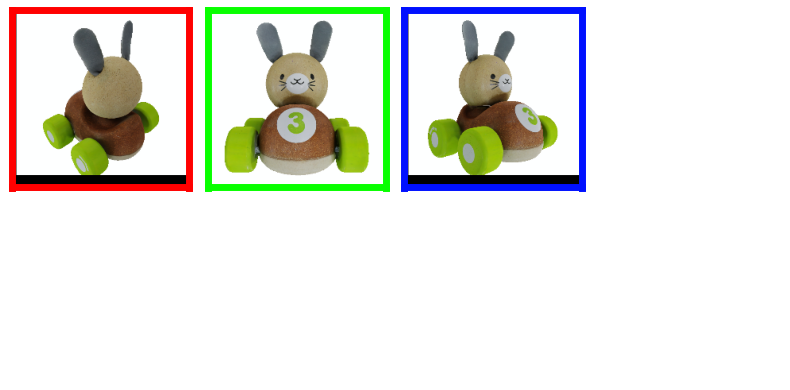

In [34]:
# Load in the wild images and crop parameters
dataset = CustomDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
)
num_frames = dataset.n
batch = dataset.get_data(ids=np.arange(num_frames))
images = batch["image"].to("cuda:0")
crop_params = batch["crop_params"].to("cuda:0")

# Visualize cropped and resized images
view_color_coded_images_from_tensor(images)

In [35]:
def plotly_scene_visualization(R_pred, T_pred, name, scale=0.1):
    num_frames = len(T_pred)
    # Construct cameras and visualize scene for quick solution
    cameras_pred = FoVPerspectiveCameras(R=R_pred, T=T_pred, fov=39)
    scenes = {name: {}}

    for i in range(num_frames):
        scenes[name][i] = FoVPerspectiveCameras(R=R_pred[i, None], T=T_pred[i, None], fov=39)

    fig = plot_scene(
        scenes,
        camera_scale=scale,
        ncols=2,
    )
    fig.update_scenes(aspectmode="data")

    cmap = plt.get_cmap("hsv")
    for i in range(num_frames):
        fig.data[i].line.color = matplotlib.colors.to_hex(cmap(i / (num_frames)))

    fig.show()

In [36]:
# Quickly initialize a coarse set of poses using MST reasoning
batched_images, batched_crop_params = images.unsqueeze(0), crop_params.unsqueeze(0)

_, hypothesis = evaluate_mst(
    model=model,
    images=batched_images,
    crop_params=batched_crop_params,
)
R_pred = np.stack(hypothesis)


# Regress to optimal translation
with torch.no_grad():
    _, _, T_pred = model(
        images=batched_images,
        crop_params=batched_crop_params,
    )

# Construct cameras and visualize scene for quick solution
# plotly_scene_visualization(R_pred, T_pred, "Initial Predicted Cameras")

# Search for optimal rotation via coordinate ascent.
# This should take less than 30 seconds.
print("Iteratively finetuning the initial MST solution.")
_, hypothesis = evaluate_coordinate_ascent(
    model=model,
    images=batched_images,
    crop_params=batched_crop_params,
)
R_final = torch.from_numpy(np.stack(hypothesis))

Iteratively finetuning the initial MST solution.


In [ ]:
def blender2torch3d_objaverse(blw2blc):
    homo = np.array([0,0,0,1])
    R_blc2blw = blw2blc[:3, :3].T
    T_blc2blw = -R_blc2blw @ blw2blc[:3, 3]
    blc2blw = np.concatenate([R_blc2blw, T_blc2blw[...,None]], axis=-1)
    blc2blw = np.concatenate([blc2blw, homo[None,...]], axis=0)
    # * blender to opengl
    blw2glw = np.array([[1,0,0,0], [0,0,1,0], [0,-1,0,0], [0,0,0,1]])
    glw2blc = np.linalg.inv(blw2glw @ blc2blw)
    # * opengl to pytorch3d
    blc2pyc = np.array([[-1,0,0,0], [0,1,0,0], [0,0,-1,0], [0,0,0,1]])
    glw2pyc = blc2pyc @ glw2blc
    return glw2pyc

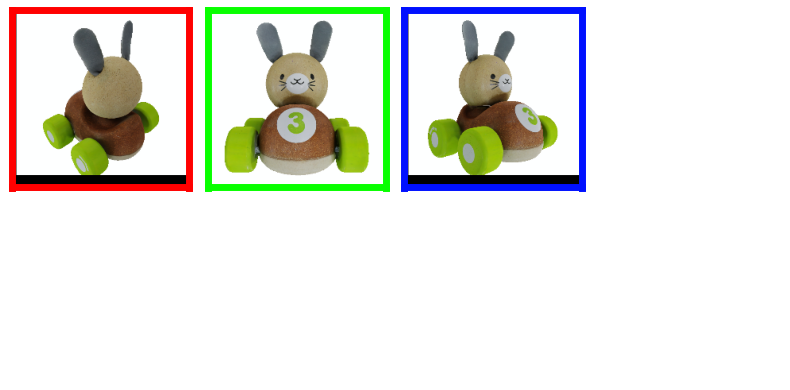

: 

In [42]:
R_final_ok = []
T_final_ok = []
R_final_pred = []
T_final_pred = []
for i in range(len(R_final)):
    R_final_i = R_final[i].T
    T_pred_i = T_pred[i].cpu()
    pose_i = torch.cat([R_final_i, T_pred_i[...,None]], dim=-1).cpu()
    R_final_pred.append(pose_i[:3, :3])
    T_final_pred.append(pose_i[:3, 3])
    pose_i = torch.from_numpy(blender2torch3d_objaverse(pose_i.numpy()))
    R_final_ok.append(pose_i[:3, :3])
    T_final_ok.append(pose_i[:3, 3])
    
R_final_ok = torch.stack(R_final_ok)
T_final_ok = torch.stack(T_final_ok)
R_final_pred = torch.stack(R_final_pred)
T_final_pred = torch.stack(T_final_pred)
plotly_scene_visualization(R_final_ok, T_final_ok, "Final Refined Cameras", 0.1)

R_final_gt = []
T_gt = []
for i in range(3):
    pose = np.load(f'{POSE_DIR}/{i:03d}.npy')
    pose = blender2torch3d_objaverse(pose)

    R_final_gt.append(pose[:3,:3])
    T_gt.append(torch.tensor(pose[:3,-1]))

R_final_gt = np.stack(R_final_gt)
T_gt = torch.stack(T_gt)
plotly_scene_visualization(R_final_gt, T_gt, "Ground Truth Cameras", 0.1)

# Visualize cropped and resized images
view_color_coded_images_from_tensor(images)

In [40]:
RT_final_pred = torch.cat(
    [
        R_final_ok,
        T_final_ok[..., None],
    ], 
    dim=-1,
).numpy()

R_final_gt = []
T_final_gt = []

for i in range(len(R_final)):
    pose = np.load(f'{POSE_DIR}/{i:03d}.npy')
    R_final_gt.append(pose[:3, :3])
    T_final_gt.append(torch.tensor(pose[:3, 3]))

R_final_gt = torch.from_numpy(np.stack(R_final_gt))
T_final_gt = torch.stack(T_final_gt)
RT_final_gt = torch.cat(
    [
        R_final_gt,
        T_final_gt[..., None],
    ], 
    dim=-1,
).numpy()

In [41]:
def get_T(RT_mtx):
    R, T = RT_mtx[:3, :3], RT_mtx[:, -1]
    RT_mtx_w2c = -R.T @ T
    elevation, azimuth, z = cartesian_to_spherical(RT_mtx_w2c[None, :])
    return elevation, azimuth, z

view_num = 3
poses = []
for i in range(view_num):
    poses.append(
        get_T(RT_final_gt[i])
    )
poses = np.stack(poses)[..., 0]

elevations = []
azimuths = []
radius = []
for i in range(view_num):
    elevations.append(
        poses[i][0].item() / np.pi,
    )
    azimuths.append(
        0.5 * ((poses[i][1].item() - poses[0][1].item()) % (2 * np.pi)) / np.pi
    )
    radius.append(
        (poses[i][2].item() - 1.5)/ 0.7,
    )

print(elevations)
print(azimuths)
print(radius)

view_num = 3
poses = []
for i in range(view_num):
    poses.append(
        get_T(RT_final_pred[i])
    )
poses = np.stack(poses)[..., 0]

elevations = []
azimuths = []
radius = []
for i in range(view_num):
    elevations.append(
        poses[i][0].item() / np.pi,
    )
    azimuths.append(
        0.5 * ((poses[i][1].item() - poses[0][1].item()) % (2 * np.pi)) / np.pi
    )
    radius.append(
        (poses[i][2].item() - 1.5)/ 0.7,
    )

print(elevations)
print(azimuths)
print(radius)

[0.33333332531716353, 0.5000000000000002, 0.5000000070739952]
[0.0, 0.6250000025828883, 0.5000000089071377]
[-1.9728031272084734e-08, -2.9802321118869e-07, 1.4395592495830556e-07]
[0.27375992413123534, 0.7257987953799209, 0.5006712934366495]
[0.0, 0.11710482217886668, 0.05882247016810725]
[-0.0003469326934751089, 0.0010597320338494906, 0.0010699936714393082]


In [44]:
# RT_final_ok = torch.cat(
#     [
#         R_final_ok,
#         T_final_ok[..., None]
#     ],
#     dim=-1
# ).numpy()
# RT_final_gt = torch.cat(
#     [
#         torch.from_numpy(R_final_gt),
#         T_gt[..., None]
#     ],
#     dim=-1
# ).numpy()[:3]
# print(RT_final_ok.shape)

# print(RT_final_gt.shape)
# # T_final_ok
# # R_final_gt
# # T_final_gt
# print(RT_final_ok[0])
# print()
# print(RT_final_gt[0])

(3, 3, 4)
(3, 3, 4)
[[ 4.14565140e-01 -4.11190105e-01  8.11824031e-01  1.75786670e-04]
 [-4.94058129e-01  6.47475852e-01  5.80242484e-01 -1.78389251e-04]
 [-7.64226488e-01 -6.41636770e-01  6.52691338e-02  1.49897242e+00]]

[[-1.00000000e+00  4.51675359e-24  6.12323432e-17  5.08050483e-24]
 [-3.06161720e-17  8.66025390e-01 -5.00000095e-01  1.19209290e-07]
 [-5.30287587e-17 -5.00000095e-01 -8.66025390e-01  1.50000000e+00]]


In [40]:
d_theta_1, d_azimuth_1, d_z_1 = get_T(RT_final_gt[0], RT_final_gt[1])
d_theta_2, d_azimuth_2, d_z_2 = get_T(RT_final_gt[0], RT_final_gt[2])

print('ground truth')
print(d_theta_1/3.14, d_theta_2/3.14)
print(d_azimuth_1/6.28, d_azimuth_2/6.28)
print(d_z_1, d_z_2)

d_theta_1, d_azimuth_1, d_z_1 = get_T(RT_final_ok[0], RT_final_ok[1])
d_theta_2, d_azimuth_2, d_z_2 = get_T(RT_final_ok[0], RT_final_ok[2])
print('ours')
# d_theta_1 = d_theta_1 % np.pi
print(d_theta_1/3.14, d_theta_2/3.14)
print(d_azimuth_1/6.28, d_azimuth_2/6.28)
print(d_z_1, d_z_2)

ground truth
[-0.0833756] [-0.0833756]
[0.2501268] [0.75038041]
[1.53686115e-07] [1.53686115e-07]
ours
[0.16711056] [-0.16664322]
[0.90276451] [0.09944085]
[1.10343427e-05] [-0.00024556]
